# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# Load data

In [2]:
mnist_train = datasets.MNIST('.', train=True, transform=Compose([ToTensor()]), download=True)
mnist_test = datasets.MNIST('.', train=False, transform=Compose([ToTensor()]), download=True)

train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=True)

# Loss functions

In [27]:
class MSE_Loss():
  def __init__(self):
    pass

  def __call__(self, a, y):
    if a.shape != y.shape:
      y = self.vectorize(a.shape[0], y)
    m = y.shape[1]
    return (1 / m) * 0.5 * np.sum((a - y) ** 2)

  def backward(self, a, y):
    if a.shape != y.shape:
      y = self.vectorize(a.shape[0], y)
    m = y.shape[1]
    self.loss = self(a, y)
    return (1 / m) * (a - y)

  def item(self):
    return self.loss

  def vectorize(self, num_classes, y):
    """Convert scalar i to 10 dimensional vector with value 1 at i-th index. In case when mse_loss is used for classification task """

    y_vectorized = np.zeros((num_classes, y.shape[0]))
    for i, y_ in enumerate(y):
      y_vectorized[y_][i] = 1

    return y_vectorized

class BCE_Loss():
  def __init__(self):
    pass

  def __call__(self, z, y):
    if z.shape != y.shape:
      y = self.vectorize(z.shape[0], y)
    m = y.shape[1]
    return (1 / m) * np.sum(np.maximum(z, 0) - z * y + np.log(1 + np.exp(- np.abs(z))))

  def backward(self, z, y):
    if z.shape != y.shape:
      y = self.vectorize(z.shape[0], y)
    m = y.shape[1]
    self.loss = self(z, y)
    return (1 / m) * (Sigmoid()(z) - y)

  def item(self):
    return self.loss

  def vectorize(self, num_classes, y):
    """Convert scalar i to 10 dimensional vector with value 1 at i-th index. In case when mse_loss is used for classification task """

    y_vectorized = np.zeros((num_classes, y.shape[0]))
    for i, y_ in enumerate(y):
      y_vectorized[y_][i] = 1

    return y_vectorized

# Activation functions

In [5]:
class Sigmoid():
  def __init__(self):
    pass

  def __call__(self, x):
    self.z_prev = x
    self.a = 1 / (1 + np.exp(-x))

    return self.a

  def backward(self, grad):
    self.grad = grad * self.a * (1 - self.a)
    return self.grad

  def __str__(self):
    return 'activation'

# Layers

In [6]:
class Linear():
  def __init__(self, input_size, output_size):
    self.w = np.random.randn(output_size, input_size) * np.sqrt(2 / input_size)
    self.b = np.random.randn(output_size, 1)

  def __call__(self, x):
    """x: input with shape (input_size, batch_size). Returns linear transformation x@w+b with shape (output_size, batch_size)"""
    self.prev_a = x
    self.z = self.w @ self.prev_a + self.b

    return self.z

  def backward(self, grad):
    self.grad_w = grad @ self.prev_a.T
    self.grad_b = grad.sum(axis=1, keepdims=True)

    self.grad = self.w.T @ grad

    return self.grad

  def update_params(self, lr):
    self.w -= lr * self.grad_w
    self.b -= lr * self.grad_b

  def __str__(self):
    return 'linear'

# ANN

In [7]:
np.random.seed(23)
class ANN():
  def __init__(self, layers):
    self.layers = layers

    self.num_layers = len(layers)

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)

    return x

  def backward(self, grad):
    for layer in self.layers[::-1]:
      grad = layer.backward(grad)

  def update_params(self, lr=1e-4):
    for layer in self.layers:
      if str(layer) != 'activation':
        layer.update_params(lr)

# Model training

In [58]:
ann = ANN([
           Linear(784, 256),
           Sigmoid(),
           Linear(256, 10)
          #  Sigmoid()
])
# loss_fn = MSE_Loss()
loss_fn = BCE_Loss()

In [59]:
epochs = 20
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr = 3e-1
sigmoid = Sigmoid()

for epoch in range(epochs):
  running_loss = 0.
  total = 0.
  correct = 0
  for i, (x, y) in enumerate(tqdm(train_loader), 1):
    x = x.reshape(x.shape[0], -1).numpy()
    y = y.numpy()

    out = ann(x.T)
    loss = loss_fn.backward(out, y)
    ann.backward(loss)
    ann.update_params(lr)

    running_loss += loss_fn.item()
    total += y.shape[0]
    correct += (sigmoid(out.T).argmax(axis=1) == y).sum()

    if i % 500 == 0:
      print(f'Iter: {i} - Loss: {running_loss / i}')
  train_loss.append(running_loss / len(train_loader))
  train_acc.append(correct / total)

  running_loss = 0.
  total = 0.
  correct = 0
  for i, (x, y) in enumerate(tqdm(test_loader), 1):
    x = x.reshape(x.shape[0], -1).numpy()
    y = y.numpy()

    out = ann(x.T)
    loss = loss_fn(out, y)

    running_loss += loss
    total += y.shape[0]
    correct += (sigmoid(out.T).argmax(axis=1) == y).sum()
  val_loss.append(running_loss / len(test_loader))
  val_acc.append(correct / total)

  print(f'Epoch: {epoch+1} - Loss: {train_loss[-1]} - Accuracy {train_acc[-1]} - Val Loss: {val_loss[-1]} - Val Accuracy: {val_acc[-1]}')

Iter: 500 - Loss: 1.2504390341905718
Iter: 1000 - Loss: 0.9824671294338452
Iter: 1500 - Loss: 0.8573700056626979




Epoch: 1 - Loss: 0.7924752496365478 - Accuracy 0.8791166666666667 - Val Loss: 0.4827797643277095 - Val Accuracy: 0.9283


Iter: 500 - Loss: 0.47920058093681017
Iter: 1000 - Loss: 0.45127826650109
Iter: 1500 - Loss: 0.4330024025474727




Epoch: 2 - Loss: 0.42145452703836134 - Accuracy 0.9391166666666667 - Val Loss: 0.34959288958805473 - Val Accuracy: 0.951


Iter: 500 - Loss: 0.3366791132061598
Iter: 1000 - Loss: 0.32957346710707097
Iter: 1500 - Loss: 0.3172126738712162




Epoch: 3 - Loss: 0.310261267923392 - Accuracy 0.9561 - Val Loss: 0.2858498664599593 - Val Accuracy: 0.9601


Iter: 500 - Loss: 0.2709852497767092
Iter: 1000 - Loss: 0.2590296365548032
Iter: 1500 - Loss: 0.2506505775806253




Epoch: 4 - Loss: 0.24768795919740708 - Accuracy 0.9657 - Val Loss: 0.2362860264020811 - Val Accuracy: 0.9659


Iter: 500 - Loss: 0.22246552044266393
Iter: 1000 - Loss: 0.21691724915027472
Iter: 1500 - Loss: 0.2111881828844938




Epoch: 5 - Loss: 0.20874219890514878 - Accuracy 0.9717333333333333 - Val Loss: 0.21185840915405582 - Val Accuracy: 0.97


Iter: 500 - Loss: 0.19033813848172698
Iter: 1000 - Loss: 0.18280516944989933
Iter: 1500 - Loss: 0.17922795228178617




Epoch: 6 - Loss: 0.17993186295116667 - Accuracy 0.9762 - Val Loss: 0.19289087672599736 - Val Accuracy: 0.9726


Iter: 500 - Loss: 0.16101658573040423
Iter: 1000 - Loss: 0.1597908688929221
Iter: 1500 - Loss: 0.15950002768700391




Epoch: 7 - Loss: 0.15895358407656807 - Accuracy 0.97905 - Val Loss: 0.18283611489825147 - Val Accuracy: 0.9747


Iter: 500 - Loss: 0.14156002525866238
Iter: 1000 - Loss: 0.13790103829952075
Iter: 1500 - Loss: 0.14021189275577517




Epoch: 8 - Loss: 0.1410904641215242 - Accuracy 0.98195 - Val Loss: 0.16952180140991194 - Val Accuracy: 0.9762


Iter: 500 - Loss: 0.1278332454456052
Iter: 1000 - Loss: 0.1291648892485748
Iter: 1500 - Loss: 0.12900919584996814




Epoch: 9 - Loss: 0.12709156489299478 - Accuracy 0.9842 - Val Loss: 0.15861687776488148 - Val Accuracy: 0.9778


Iter: 500 - Loss: 0.11331827389560217
Iter: 1000 - Loss: 0.11837907979450026
Iter: 1500 - Loss: 0.1152257617060039




Epoch: 10 - Loss: 0.11486110059895625 - Accuracy 0.9861 - Val Loss: 0.15555600142431034 - Val Accuracy: 0.9773


Iter: 500 - Loss: 0.10298506255309715
Iter: 1000 - Loss: 0.10303882952902141
Iter: 1500 - Loss: 0.10450857749701283




Epoch: 11 - Loss: 0.10524000260743785 - Accuracy 0.9875166666666667 - Val Loss: 0.14512330377904786 - Val Accuracy: 0.9781


Iter: 500 - Loss: 0.0941228105298704
Iter: 1000 - Loss: 0.09654238968054739
Iter: 1500 - Loss: 0.09610942811799479




Epoch: 12 - Loss: 0.09572937983917397 - Accuracy 0.9891 - Val Loss: 0.14685031257629805 - Val Accuracy: 0.9783


Iter: 500 - Loss: 0.08563353204283533
Iter: 1000 - Loss: 0.08556247735230954
Iter: 1500 - Loss: 0.08731296220281949




Epoch: 13 - Loss: 0.08770826901530542 - Accuracy 0.9903 - Val Loss: 0.14091832704755133 - Val Accuracy: 0.9799


Iter: 500 - Loss: 0.0780672567693406
Iter: 1000 - Loss: 0.08012888917842666
Iter: 1500 - Loss: 0.08182520576369452




Epoch: 14 - Loss: 0.08042668757144675 - Accuracy 0.9915333333333334 - Val Loss: 0.1419021314392416 - Val Accuracy: 0.9788


Iter: 500 - Loss: 0.07638925403502736
Iter: 1000 - Loss: 0.074433042600942
Iter: 1500 - Loss: 0.07295430920577306




Epoch: 15 - Loss: 0.07394553905468775 - Accuracy 0.9919666666666667 - Val Loss: 0.13648135675084064 - Val Accuracy: 0.9803


Iter: 500 - Loss: 0.06808173352261235
Iter: 1000 - Loss: 0.06770757852855003
Iter: 1500 - Loss: 0.06782695425461457




Epoch: 16 - Loss: 0.06815450900932574 - Accuracy 0.99335 - Val Loss: 0.13487258956652012 - Val Accuracy: 0.9812


Iter: 500 - Loss: 0.06355618745202773
Iter: 1000 - Loss: 0.06348191319554508
Iter: 1500 - Loss: 0.061617311492227815




Epoch: 17 - Loss: 0.06266250142793135 - Accuracy 0.9944 - Val Loss: 0.13283313406188224 - Val Accuracy: 0.9805


Iter: 500 - Loss: 0.055409521043192356
Iter: 1000 - Loss: 0.05727182084326991
Iter: 1500 - Loss: 0.056757156637056806




Epoch: 18 - Loss: 0.058254157425286404 - Accuracy 0.9948166666666667 - Val Loss: 0.1340012875939798 - Val Accuracy: 0.9813


Iter: 500 - Loss: 0.047027752606644116
Iter: 1000 - Loss: 0.05229121013415941
Iter: 1500 - Loss: 0.05270735221018366




Epoch: 19 - Loss: 0.053705386513358724 - Accuracy 0.9957166666666667 - Val Loss: 0.1331611097162888 - Val Accuracy: 0.9814


Iter: 500 - Loss: 0.04844504635409219
Iter: 1000 - Loss: 0.047173813286778096
Iter: 1500 - Loss: 0.04902882198343144




Epoch: 20 - Loss: 0.04995561448965743 - Accuracy 0.99605 - Val Loss: 0.13169181140502004 - Val Accuracy: 0.982


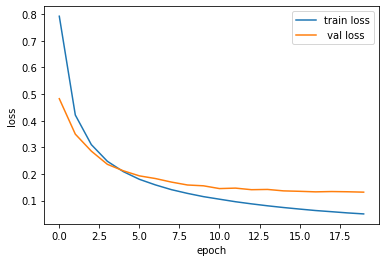

In [60]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label=' val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

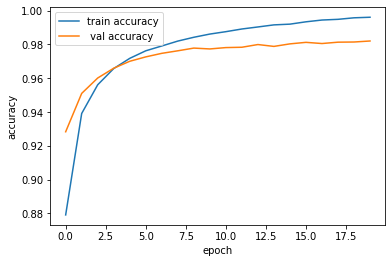

In [61]:
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label=' val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

# Make predictions

In [67]:
x, y = next(iter(test_loader))
x = x.reshape(x.shape[0], -1).numpy()
y = y.numpy()

In [68]:
out = ann(x.T)

In [69]:
acc = (sigmoid(out.T).argmax(axis=1) == y).sum() / len(x)
print(f'Test set accuracy {acc}')

Test set accuracy 0.984375


True label [4], Predicted: [9]


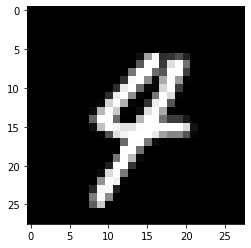

In [73]:
missclassified_idx = np.arange(len(x))[(out.argmax(axis=0) != y)]
idx = np.random.choice(missclassified_idx, size=1)
plt.imshow(x[idx].reshape(28,28), cmap='gray')
print(f'True label {y[idx]}, Predicted: {sigmoid(ann(x[idx].reshape(1, 784).T)).argmax(axis=0)}')